<a href="https://colab.research.google.com/github/jjhurtadoa/Modelos-/blob/main/imdbEsp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocesamiento

No es necesario correrlo de nuevo, al final de esta etapa se genera un archivo para entrenar el modelo. Se deja para ilustrar cómo se realiza

In [ ]:
pip install spacy==2.3.5

In [ ]:
!spacy download es_core_news_sm

In [ ]:
import pandas as pd 
import nltk 
nltk.download('stopwords')
import spacy
from nltk.corpus import stopwords

In [ ]:
#Se debe poner la ruta específica donde esté el archivo 'data_esp.csv'
df=pd.read_csv('/content/drive/MyDrive/Tecno-Inclusion/MineriaTexto/Español_Analisis/data_esp.csv') 
df = df.drop(['Unnamed: 0','review'],axis=1)
df.rename(columns={'esp':'review'}, inplace= True)
df

Lematización y limpieza de texto apoyados en la librería spacy

In [ ]:
nlp = spacy.load('es_core_news_sm')

def normalize(text):
    doc = nlp(text)
    lemmas = [t.lemma_ for t in doc if not t.is_punct | t.is_stop ]
    lexical_tokens = [t.lower() for t in lemmas if len(t) > 3 and  t.isalpha()]
    #lemmas = [tok.lemma_ for tok in lexical_tokens]
    text = " ".join(lexical_tokens)

    return text
normalized = normalize("Soy un texto de prueba. ¿Cuántos tokens me quedarán después de la normalización?")
normalized

'texto probar tokens quedar normalización'

In [ ]:
df['Processed_Reviews'] = df.review.apply(lambda x: normalize(x))
df.head()

,sentiment,review,Processed_Reviews
0,0,"Una vez más, el Sr. Costner ha arrastrado una ...",costner arrastrar película necesario aparte ex...
1,0,Este es un ejemplo de por qué la mayoría de la...,mayoría película acción genérico aburrir realm...
2,0,"En primer lugar, odio a esos raperos morones, ...",odiar rapero morón poder actuar tener pistola ...
3,0,Ni siquiera los Beatles podrían escribir canci...,siquiera beatles escribir canción gustar walte...
4,0,Imágenes de latón (las películas no son una pa...,imágenes latón película palabra apropiar realm...


In [ ]:
df.to_csv('data_processed.csv')

# Preparacion de datos

In [ ]:
from importlib import  reload
import sys
from imp import  reload
import warnings
warnings.filterwarnings('ignore') 
  
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.model_selection import train_test_split


In [ ]:
import pandas as pd 
#Se debe poner la ruta específica donde esté el archivo 'data_processed.csv'
df=pd.read_csv('/content/drive/MyDrive/Tecno-Inclusion/MineriaTexto/Español_Analisis/data_processed.csv')
df = df.drop(['Unnamed: 0'],axis=1)
df

,sentiment,review,Processed_Reviews
0,0,"Una vez más, el Sr. Costner ha arrastrado una ...",costner arrastrar película necesario aparte ex...
1,0,Este es un ejemplo de por qué la mayoría de la...,mayoría película acción genérico aburrir realm...
2,0,"En primer lugar, odio a esos raperos morones, ...",odiar rapero morón poder actuar tener pistola ...
3,0,Ni siquiera los Beatles podrían escribir canci...,siquiera beatles escribir canción gustar walte...
4,0,Imágenes de latón (las películas no son una pa...,imágenes latón película palabra apropiar realm...
...,...,...,...
9563,1,Al ver que el promedio de votos era bastante b...,promediar voto secretario tender video pensar ...
9564,1,"La trama tenía algunos giros desgraciados, inc...",tramar giro desgraciar increíble químico brook...
9565,1,Estoy sorprendido de cómo esta película (y la ...,sorprender película mayoría promediar estrella...
9566,1,Una Navidad juntos en realidad llegó antes de ...,navidad junto realidad criar john denver canci...


In [ ]:
MAX_FEATURES = 6000
EMBED_SIZE = 128
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(df['Processed_Reviews'])
list_tokenized_train = tokenizer.texts_to_sequences(df['Processed_Reviews'])
  
RNN_CELL_SIZE = 32
  
MAX_LEN = 130  # Since our mean length is 128.5


X = pad_sequences(list_tokenized_train, maxlen=MAX_LEN)
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# Creación del modelo

In [ ]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
          
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
          
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [ ]:
sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)

In [ ]:
lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

In [ ]:
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])
context_vector, attention_weights = Attention(10)(lstm, state_h)
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1)
output = Dense(1, activation="sigmoid")(dropout)
  
model = keras.Model(inputs=sequence_input, outputs=output)

In [ ]:
# summarize layers
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 130)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 130, 128)     768000      input_1[0][0]                    
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       (None, 130, 64)      41216       embedding[0][0]                  
__________________________________________________________________________________________________
bi_lstm_1 (Bidirectional)       [(None, 130, 64), (N 24832       bi_lstm_0[0][0]                  
____________________________________________________________________________________________

In [ ]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=METRICS)

In [ ]:
BATCH_SIZE = 100
EPOCHS = 5
history = model.fit(X_train,y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2)

Epoch 1/5
54/54 [==============================] - 33s 430ms/step - loss: 0.6041 - tp: 2277.0000 - fp: 1320.0000 - tn: 1324.0000 - fn: 436.0000 - accuracy: 0.6722 - precision: 0.6330 - recall: 0.8393 - auc: 0.7611 - val_loss: 0.3976 - val_tp: 641.0000 - val_fp: 148.0000 - val_tn: 494.0000 - val_fn: 57.0000 - val_accuracy: 0.8470 - val_precision: 0.8124 - val_recall: 0.9183 - val_auc: 0.9303
Epoch 2/5
54/54 [==============================] - 22s 410ms/step - loss: 0.2637 - tp: 2482.0000 - fp: 324.0000 - tn: 2320.0000 - fn: 231.0000 - accuracy: 0.8964 - precision: 0.8845 - recall: 0.9149 - auc: 0.9567 - val_loss: 0.3287 - val_tp: 587.0000 - val_fp: 72.0000 - val_tn: 570.0000 - val_fn: 111.0000 - val_accuracy: 0.8634 - val_precision: 0.8907 - val_recall: 0.8410 - val_auc: 0.9422
Epoch 3/5
54/54 [==============================] - 22s 407ms/step - loss: 0.1407 - tp: 2605.0000 - fp: 130.0000 - tn: 2514.0000 - fn: 108.0000 - accuracy: 0.9556 - precision: 0.9525 - recall: 0.9602 - auc: 0.9846 

In [ ]:
X_test

array([[   0,    0,    0, ..., 1202,    1,   19],
       [   0,    0,    0, ...,   61,   35,    1],
       [   0,    0,    0, ...,  646,  645,  147],
       ...,
       [   0,    0,    0, ...,    1,   10,  357],
       [   0,    0,    0, ..., 5453,  149,  268],
       [   0,    0,    0, ..., 1413, 4579, 1394]], dtype=int32)

In [ ]:
prediction = model.predict(X_test)
y_pred = [1 if (x > 0.5) else 0 for x in prediction]


              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1432
           1       0.85      0.82      0.83      1439

    accuracy                           0.83      2871
   macro avg       0.84      0.83      0.83      2871
weighted avg       0.84      0.83      0.83      2871



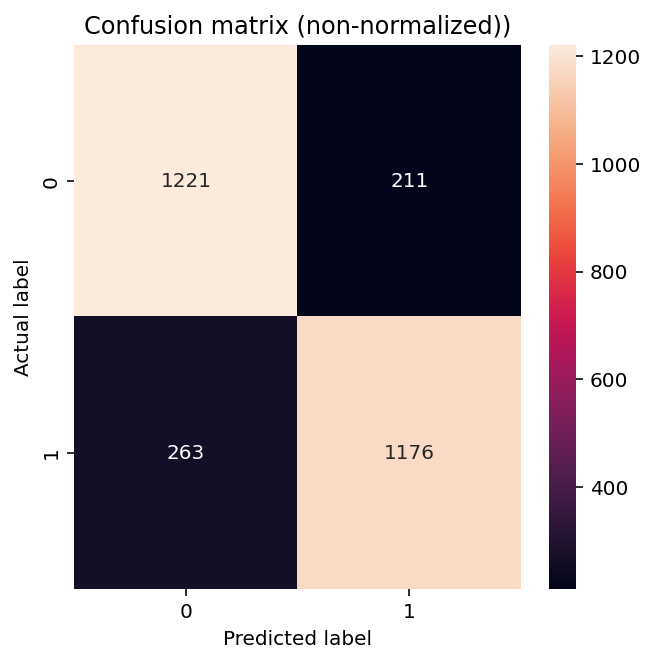

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
  
report = classification_report(y_test, y_pred)
print(report)
  
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
  
plot_cm(y_test, y_pred)

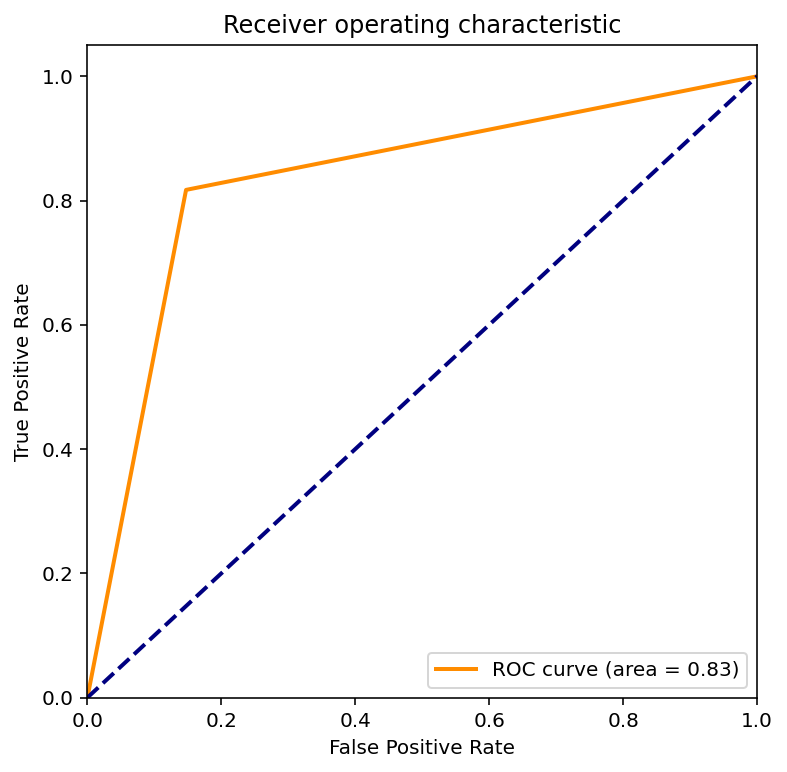

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
  
mpl.rcParams["figure.figsize"] = (6, 6)
  
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_auc_score
  
# Binarize the output
y_bin = label_binarize(y_test, classes=[0, 1])
n_classes = 1
  
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in  range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test.ravel(), y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])
  
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
def prediccion(texto):
  lista=[]
  lista.append(texto)
  lista= [normalize(x) for x in lista]
  tokenized = tokenizer.texts_to_sequences(lista)
  test = pad_sequences(tokenized, maxlen=MAX_LEN)
  prediction = model.predict(test)
  print( prediction)
  if ( prediction > 0.5) : print("POSITIVO")
  else: print("NEGATIVO")

  print(test)

#Predicción de 1 estrella IMDB (Armagedon)
texto= "Me gustan las películas de acción. Tengo una debilidad por las películas con diálogos malos y actuaciones de mala calidad. Así que me he devanado los sesos para encontrar uno de mis placeres culpables que fuera peor que esta superproducción. No puedo. Es difícil encontrar un pedazo de mierda más grande que este vehículo de Bruce Willis. Armageddon es la historia (y uso este término de forma imprecisa) de un equipo de \"Superperforadores\" que vuelan para destruir un asteroide antes de que destruya la Tierra. ¿Es realista? La verdad es que no. ¿Pero a quién le importa? Es una película de acción. La película comienza con un par de escenas diseñadas para presentar la amenaza y los personajes. Bruce Willis es el líder más duro del equipo, y pasa su primer tiempo en pantalla persiguiendo a Ben Affleck con una pistola por el imperdonable acto de acostarse con su hija. Por alguna razón, eso no me hizo reír. El equipo es llamado porque son las únicas personas en todo el mundo que pueden perforar el asteroide. Vale, estoy dispuesto a aceptar esa premisa si nos lleva a la acción, el supuesto meollo de la película. Más intentos de humor, con cada personaje saliendo a hacer alguna locura antes de despegar. Una vez más, es una lástima. Finalmente, despegan. Aquí es donde la película realmente me ha hecho polvo. Llegan a la roca y se ponen a trabajar. ¿Te lo puedes creer? ¡¡¡Nada funciona bien y todo tiene una cuenta atrás de suspenso!!! ¡Whoah! Diez, nueve, ocho... uno... ¡Oh, sorpresa, hemos salvado el día otra vez! Y no me hagas hablar de la cámara espasmódica. Cuando la vi en el cine pensé que me iba a enfermar. Sólo puedo suponer que intentaban tapar los enormes agujeros dejados por las insípidas interpretaciones cortando a un plano diferente cada pocos segundos (y esto lo dice alguien criado en la MTV, el mismo señor de la poca atención).Justo cuando pensaba que no podía ser peor... esperen, hay un final lacrimógeno fabricado que estaba tan hilvanado que hacía que el resto de la película fuera prácticamente Ciudadano Kane.Resumen: Las ocurrencias no eran ingeniosas. La trama... bueno, ya dije que la dejaría pasar. La actuación fue mala. Realmente mala. Ni siquiera Billy Bob pudo superar el guión, que era peor. El trabajo de cámara - de nuevo, malo. (Ni siquiera he mencionado la escena de amor más tonta de la historia del cine - piensa en las galletas de animales).Valoración: 1 de 10. (Doy medio punto por Steve Buscemi, que me hace sonreír en contra de mi voluntad y otro medio punto por las veces que pude mirar a la encantadora Liv Tyler e intentar ignorar su actuación) Esta es, de lejos, la peor película que he ido a ver al cine... nunca."

prediccion(texto)

[[0.00116634]]
NEGATIVO
[[ 718  678  678  295  396  199    1   55    1   32    5  644  190  788
     4  924 1490  623  513  409  306   97  683  992  769   61  119  142
   409   48   31    6   52 4936 1453 1050 1018  592   55    1 1023  153
     4   45 1091 3530 1739  197 3530    1    3 3042  947   93   19   75
   206  846  401  492 2003  491  499   27  152  148   66   20 1030  144
   338 4222  585  900   69 1863 1133  204  586  784   73 1826  580   20
    19   29 5527   27  194    1  819 2661 2057  874   42   76   69   71
    13   10    3   10  141 1163  593   89  148   10  141  278    5  103
   169    2   66   20 3545   40  805 1503 2005   40   19   56  410 2628
  1065   13    1   66]]


In [ ]:
#Predicción de 10 estrellas de IMDB (La casa de papel)
prediccion("Este episodio fue probablemente el mejor de toda la serie porque es emocionante durante todo el visionado, no hay una sola parte de este episodio que sea aburrida. También hay que destacar a Esther Martínez Lobato por incorporar las emociones tan bien a lo largo del episodio.")

[[0.9978632]]
POSITIVO
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0  116   80   23  654 4666  116   82  684
  3927 1802  481  116]]


In [ ]:
#Predicción de 1 estrella de IMDB  (Sharknado)
prediccion("Aunque le doy una estrella, recomiendo encarecidamente a todo el mundo que vea esta película. No porque sea buena o tenga un solo factor redentor, sino porque si Ed Wood se propuso intencionadamente con un presupuesto ilimitado hacer la peor película de la historia, no podría haber hecho algo tan malo. La ley de los grandes números parecería implicar que en 86 minutos tendría que acertar en algo por accidente, y sin embargo esta película no lo hace. Un segundo vistazo a Alien Apocalypse (que hay que admitir que requiere una naturaleza masoquista para emprenderla) al menos revela una cinematografía pasable y una iluminación consistente. Y sin embargo, Sharknado se eleva por encima de las matemáticas para darnos una película que es mala en todos los sentidos posibles.La continuidad es ignorada por completo. La misma escena pasa de la luz del día al atardecer, de la lluvia al sol, de la tormenta a la playa tranquila, con cada nuevo ángulo de cámara. Es tan descaradamente mala que te distrae de las incoherencias más sutiles, como los objetos que se mueven, el atuendo, el viento o la calidad de la película de un corte a otro. Si consigues cerrar los ojos, te dejas llevar inmediatamente por el sonido. Cómo se las arregló el editor de sonido para ponerse a trabajar en lo que tuvo que ser una borrachera de ácido de proporciones épicas para garantizar estos resultados me resulta imposible. Me resisto a sugerir el uso de la tecnología de nivelación de sonido de tu equipo de música por miedo a que tu sistema de sonido se derrita por el esfuerzo. Uno se resiste a señalar con el dedo la suspensión de la incredulidad cuando se trata de una película cuya premisa son los tiburones en los tornados, pero sea cual sea el nivel con el que se planea llegar, es casi seguro que se va a quedar muy corto. Esta película tiene más momentos WTF en 86 minutos que los que podría tener Lost en 86 temporadas. Y todo el mundo puede jugar, no sólo los que tienen un conocimiento práctico de la cizalladura del viento o de la física que mantiene un helicóptero en el aire. Si has jugado al billar, has pescado, has hecho surf, has conducido un coche en aguas de más de cinco centímetros de profundidad, has estado expuesto a la gravedad o has interactuado de alguna manera con el mundo que te rodea o lo has comprendido, esta película tiene algo con lo que decir ¡¿qué?!. Y aunque se podría pensar que una vez que se han unido los malos efectos especiales, el mal montaje y el mal sonido, se obtendría al menos un Bruce Campbell del reparto al que agarrarse. Aquí no es así, ya que todos los actores hicieron una interpretación que demuestra que estaban más confundidos que el espectador sobre lo que estaba sucediendo. Podríamos suponer que es porque les dieron el guión desordenado, pero como espectador del producto final no estoy seguro de haber visto las escenas en orden, son así de inconexas. He intentado por todos los medios encontrar algo que se haya hecho bien o digno de mención en esta película y lo único que se me ocurre es que es la única película que he visto que ha fracasado en absolutamente todos los niveles. Si intentaras hacer una película tan mala, sin quererlo, harías algo bien por pura casualidad. Y ese es su único punto de luz brillante. Que sería casi imposible volver a hacer algo tan terrible.")

[[0.00183567]]
NEGATIVO
[[ 257    1  204  762   69 1445  305 1299 1704  305 2373 3095  439 1317
  1745  166  166  838 2989  720 1258  305  409   77  286 1077  305  397
  2989  967 1754 2890 2276    1  448  592 1483 1284  406 1346  112  129
   453  204    1  178   58  511   52   12 1176 2317 1118  987  118 2098
   647   30   12   30 1671   30 2873   30  558 1974  534  601   30 1474
  4391   30 3158   52  949   30 1535    1   20  798   10   88  143 1954
   305   41  924  288   16 1133  424  795  157  108  144   89 2210  157
  1333  129    7    5 1132 3209  338  290   17 1668 2259    1   31  606
    31    1    7 1470  224 1101  338    1   10   27  572 5105   31   40
   196  838   54  133]]
